## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [94]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
import seaborn as sns

In [95]:
# Load the train and test data.
mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv')
mailout_test = pd.read_csv('./Udacity_MAILOUT_052018_TEST.csv')

# Load the attributes dataset.
dias_attributes = pd.read_excel('./DIAS Attributes - Values 2017.xlsx')

C:\Users\david\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [96]:
mailout_train.shape

(42962, 368)

In [97]:
mailout_test.shape

(42833, 367)

In [98]:
mail_response = mailout_train.RESPONSE.value_counts(dropna = False)
df_resp = pd.DataFrame({'RESPONSE':mail_response.index, 'percentage of data': mail_response.values})
df_resp['percentage of data'] = 100 * df_resp['percentage of data']/mailout_train.shape[0]

In [99]:
mail_response

0    42430
1      532
Name: RESPONSE, dtype: int64

In [100]:
df_resp

,RESPONSE,percentage of data
0,0,98.761696
1,1,1.238304


#### **Discusion:**
**`98.76%` of the people who were contacted through the mailout did not become customers.  This dataset is very imbalanced.**

**The difference between the training and the test dataframes are the RESPONSE and Unnamed columns.**

In [8]:
def content_fix(df, column):
    '''
    This function corrects the characters used in the CAMEO columns, which raised
    the erros when we load the population and customer datasets.
    '''
    columns = column
    
    # Replace and reformat the columns to float.
    df[columns] = df[columns].replace({'X': np.nan, 
                                       'XX': np.nan, 
                                       ' ': np.nan, 
                                       '': np.nan})
    if (column == 'CAMEO_DEUG_2015') or (column == 'CAMEO_INTL_2015'):
        df[columns] = df[columns].astype('float')
    
    return df

In [9]:
def dias_attributes_fix(attributes):
    '''
    Function reformats dias_attributes so that if is usable.
    Drops Unnamed: 0 columns, and moves the column names from
    the first row, forward fills the null values and generates
    a cols_to_keep 
    '''
    # Formating dais_attributes dataframe.
    attributes.drop(columns = 'Unnamed: 0', inplace = True)
    attributes.drop(index = 0, axis = 0, inplace = True)
    attributes.columns = ['Attribute',	'Description', 'Value', 'Meaning']
    attributes.reset_index(drop = True, inplace = True)
    
    # Lets fill the nan values with the previous values.
    attributes.fillna(method = 'ffill', inplace = True)

    cols_to_keep = attributes['Attribute'].unique().tolist()
    
    print('Dias_attributes has been transformed.')
    
    return attributes, cols_to_keep

In [10]:
attributes_df, cols_to_keep = dias_attributes_fix(dias_attributes)

Dias_attributes has been transformed.


In [11]:
def unknowns_df(attributes):
    '''
    This function formats the dais_attributes data and gives the unknown values
    in the data have been assigned.
    '''
    # drop the numerical values columns from attributes we wnat to keep them.
    #attributes = attributes.set_index('Attribute')
    #attributes = attributes.drop(['ANZ_HAUSHALTE_AKTIV',
    #                            'ANZ_HH_TITEL', 
    #                            'ANZ_PERSONEN', 
    #                            'ANZ_TITEL',
    #                            'GEBURTSJAHR',
    #                            'KBA13_ANZAHL_PKW',
    #                            'MIN_GEBAEUDEJAHR'], 
    #                          axis=0)
    
    #uk_attributes = attributes.reset_index()
    # which meaning might indicate unknowns.
    unknown = attributes[attributes['Meaning'].str.contains('unknown')]
    
    # Fix the cells with two values.
    unknown['Value'] = unknown['Value'].astype(str)
    unknown_2 = unknown['Value'].str.split(',').apply(pd.Series)
    unknown_2.index = unknown.set_index(['Attribute', 'Description', 'Meaning']).index
    unknown_2 = unknown_2.stack().reset_index(['Attribute', 'Description', 'Meaning'])
    unknown_2 = unknown_2.reset_index()
    unknown_2.drop(columns = 'index', inplace = True)
    unknown_2.rename(columns = {0: 'Value'}, inplace = True)
    
    # Convert the values into interger values.
    unknown_2['Value'] = unknown_2['Value'].astype('int64')
    
    return unknown_2

In [12]:
unknown_values_df = unknowns_df(attributes_df)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
unknown_values_df['Value'].value_counts()

-1    230
 9     75
 0     19
Name: Value, dtype: int64

In [14]:
def cleaning(df, unknown_values_df, cols_to_keep, train = 'train'):
    '''
    This function converts the unknown values in the dataframe to null values,
    drops rows that have more than 50% missing data and drop columns we have no
    definitions for in attributes.
    '''
    # Drop the Unnamed:0 column in the data
    if 'Unnamed: 0' in df.columns:
        df.drop(columns = 'Unnamed: 0', inplace = True)
    
    iden = df.pop('LNR')
    # Fix the CAMEO_DEU_2015 missing values recorded as 'X' or 'XX'.
    df = content_fix(df, column = 'CAMEO_DEUG_2015')
    df = content_fix(df, column = 'CAMEO_DEU_2015')

    # Takes the unknown values recorded in Meaning and change them in df for null.
    print('-------------------------------------------------------------')
    print('----- Converting unknown values to null in training df. -----')
    print('-------------------------------------------------------------')
    #---------------------------------------------------------------------------------------
    for index in unknown_values_df.iterrows():
        missing_values = int(index[1]['Value'])
        attrib = index[1]['Attribute']
        
        if attrib not in df.columns:
            continue
        
        if isinstance(missing_values, int):
            df[attrib].replace(missing_values, np.nan, inplace=True)
        elif isinstance(missing_values, str):
            eval("df[dias_attributes].replace(["+missing_values+"], np.nan, inplace=True)")
    
    print('-------------------------------------------------------------')
    print('-------------- Conversion of data complete. -----------------')
    print('-------------------------------------------------------------')
    
    if train == 'train':
        # Assess how many missing values per row then remove those over 50%.
        row_nulls = df.isnull().sum(axis = 1)
        cols_len = df.shape[1]
        df = df.loc[row_nulls[row_nulls <= 0.5 * cols_len].index]
        df.reset_index(drop = True, inplace = True)
        
        
        # Split the features and lebels
        train_response = df['RESPONSE']
        features = df.drop('RESPONSE', axis = 1)
        
        features = features.filter(cols_to_keep)
        
        print('-------------------------------------------------------------')
        print('----------  features and train_response ready. --------------')
        print('-------------------------------------------------------------')
        
        return features, train_response, iden
    elif train == 'customers':
        # For the customer data take the customer specific columns.
        cust_response = df[['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]
        features = df.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], 
                           axis = 1)
        features = features.filter(cols_to_keep)
        
        print('-------------------------------------------------------------')
        print('-------------  customer features and type ready -------------')
        print('-------------------------------------------------------------')
        
        return features, cust_response, iden
        
    else:
        # Drop columns not in attributes.
        features = df.filter(cols_to_keep)
        
        print('-------------------------------------------------------------')
        print('-------------------  features ready -------------------------')
        print('-------------------------------------------------------------')
        
        return features, iden

In [15]:
train_features, train_response, train_lrn  = cleaning(mailout_train, 
                             unknown_values_df, 
                             cols_to_keep, 
                             train = 'train')

-------------------------------------------------------------
----- Converting unknown values to null in training df. -----
-------------------------------------------------------------
-------------------------------------------------------------
-------------- Conversion of data complete. -----------------
-------------------------------------------------------------
-------------------------------------------------------------
----------  features and train_response ready. --------------
-------------------------------------------------------------


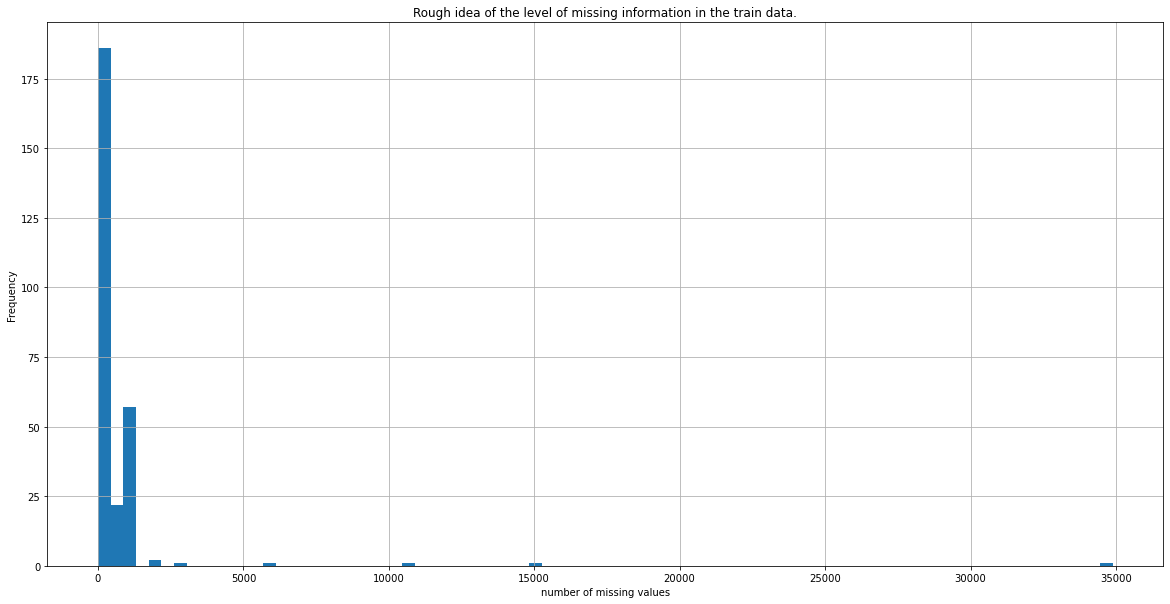

In [16]:
# Missining values in pop_features.
train_features.isnull().sum().plot(kind='hist', bins = 80, figsize = (20,10));
plt.title('Rough idea of the level of missing information in the train data.')
plt.xlabel('number of missing values')
plt.grid()

There are fewer columns that have a large number of missing values but to know more we should dig a little more.  First lets look at how much data is missing from the test data.

In [17]:
test_features, test_lrn  = cleaning(mailout_test, 
                             unknown_values_df, 
                             cols_to_keep, 
                             train = 'test')

-------------------------------------------------------------
----- Converting unknown values to null in training df. -----
-------------------------------------------------------------
-------------------------------------------------------------
-------------- Conversion of data complete. -----------------
-------------------------------------------------------------
-------------------------------------------------------------
-------------------  features ready -------------------------
-------------------------------------------------------------


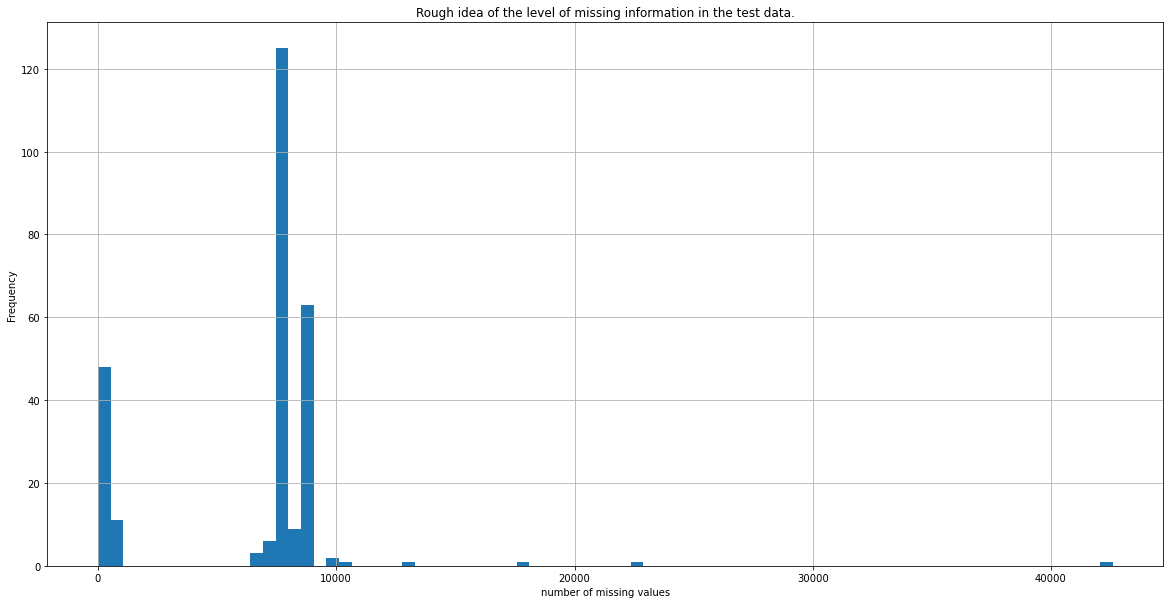

In [18]:
# Missining values in pop_features.
test_features.isnull().sum().plot(kind='hist', bins = 80, figsize = (20,10));
plt.title('Rough idea of the level of missing information in the test data.')
plt.xlabel('number of missing values')
plt.grid()

It appears at fist glace that there is more missing data in the test dataset that in the training dataset.

In [19]:
train_missing_over30p = train_features.isnull().mean()[train_features.isnull().mean() > 0.3] * 100
train_missing_over30p.reset_index().rename({'index': 'Attribute', 0: '% missing'}, axis = 1)

,Attribute,% missing
0,AGER_TYP,30.506639
1,KBA05_BAUMAX,43.070040
2,TITEL_KZ,99.407306


In [20]:
test_missing_over30p = test_features.isnull().mean()[test_features.isnull().mean() > 0.3] * 100
test_missing_over30p.reset_index().rename({'index': 'Attribute', 0: '% missing'}, axis = 1)

,Attribute,% missing
0,AGER_TYP,42.016669
1,ALTER_HH,30.889735
2,KBA05_BAUMAX,53.286018
3,TITEL_KZ,99.425676


Let's drop these 4 coulumns from both datasets.

In [21]:
# Dropping these 4 columns.
train_features.drop(['AGER_TYP', 'ALTER_HH', 'KBA05_BAUMAX', 'TITEL_KZ'], axis = 1, inplace=True)
test_features.drop(['AGER_TYP', 'ALTER_HH', 'KBA05_BAUMAX', 'TITEL_KZ'], axis = 1, inplace=True)

In [22]:
print('Training data shape: ', train_features.shape)
print('Test data shape: ', test_features.shape)

Training data shape:  (35094, 268)
Test data shape:  (42833, 268)


In [23]:
# Best columns to keep from best_cols using SelectKBest method.

#best_cols = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_TITEL',
#             'CAMEO_DEUG_2015', 'CJT_GESAMTTYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
#             'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12',
#             'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
#             'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
#             'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
#             'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12',
#             'D19_VERSI_ANZ_24', 'EWDICHTE', 'FINANZTYP', 'FINANZ_ANLEGER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
#             'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GEBURTSJAHR',
#             'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HH_EINKOMMEN_SCORE', 'KBA05_ALTER4', 'KBA05_ANTG2', 'KBA05_ANTG4',
#             'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_KRSAQUOT',
#             'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSZUL', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ',
#             'KBA05_MAXSEG', 'KBA05_MOD1', 'KBA05_MOD3', 'KBA05_MOD8', 'KBA05_MOTOR', 'KBA05_SEG10', 'KBA05_SEG4', 'KBA05_SEG5',
#             'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_VORB0', 'KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL4',
#             'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_61', 'KBA13_ANZAHL_PKW', 'KBA13_AUDI', 'KBA13_BMW', 'KBA13_CCM_1500',
#             'KBA13_CCM_2000', 'KBA13_CCM_2500', 'KBA13_CCM_2501', 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_FIAT',
#             'KBA13_HALTER_40', 'KBA13_HALTER_45', 'KBA13_HALTER_55', 'KBA13_HALTER_65', 'KBA13_HALTER_66',
#             'KBA13_HERST_AUDI_VW', 'KBA13_HERST_BMW_BENZ', 'KBA13_HERST_EUROPA', 'KBA13_HERST_FORD_OPEL', 'KBA13_KMH_140',
#             'KBA13_KMH_211', 'KBA13_KMH_250', 'KBA13_KMH_251', 'KBA13_KRSHERST_AUDI_VW', 'KBA13_KRSHERST_BMW_BENZ',
#             'KBA13_KRSZUL_NEU', 'KBA13_KW_121', 'KBA13_MERCEDES', 'KBA13_MOTOR', 'KBA13_OPEL', 'KBA13_PEUGEOT',
#             'KBA13_SEG_GROSSRAUMVANS', 'KBA13_SEG_MINIVANS', 'KBA13_SEG_MINIWAGEN', 'KBA13_SEG_OBEREMITTELKLASSE',
#             'KBA13_SEG_OBERKLASSE', 'KBA13_SEG_SPORTWAGEN', 'KBA13_SEG_UTILITIES', 'KBA13_SEG_VAN', 'KBA13_SITZE_4',
#             'KBA13_SITZE_5', 'KBA13_SITZE_6', 'KBA13_VORB_0', 'KBA13_VW', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',
#             'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'MIN_GEBAEUDEJAHR',
#             'ONLINE_AFFINITAET', 'ORTSGR_KLS9', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX',
#             'PLZ8_GBZ', 'PLZ8_HHZ', 'PRAEGENDE_JUGENDJAHRE', 'RELAT_AB', 'RETOURTYP_BK_S', 'SEMIO_DOM', 'SEMIO_ERL',
#             'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST', 'SEMIO_PFLICHT', 'SEMIO_RAT',
#             'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_VERT', 'SHOPPER_TYP', 'VERS_TYP', 'WOHNDAUER_2008', 'W_KEIT_KIND_HH',
#             'ZABEOTYP', 'CAMEO_DEU_2015_2D', 'CAMEO_DEU_2015_5D', 'CAMEO_DEU_2015_6B', 'CAMEO_DEU_2015_7B',
#             'CAMEO_DEU_2015_7C', 'CAMEO_DEU_2015_9E', 'OST_WEST_KZ_W']

# Sums_now list which used the PCA method for feature selection.
best_cols = ['KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'LP_LEBENSPHASE_FEIN', 'MIN_GEBAEUDEJAHR', 'D19_GESAMT_ONLINE_QUOTE_12',
             'D19_VERSAND_ONLINE_QUOTE_12', 'GEBURTSJAHR', 'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'LP_LEBENSPHASE_GROB',
             'D19_VERSAND_DATUM', 'D19_GESAMT_DATUM', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_24',
             'D19_GESAMT_ANZ_12', 'D19_VERSAND_ANZ_12', 'PRAEGENDE_JUGENDJAHRE', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'CAMEO_DEUG_2015',
             'D19_KONSUMTYP', 'CJT_GESAMTTYP', 'ONLINE_AFFINITAET', 'MOBI_REGIO', 'HH_EINKOMMEN_SCORE', 'KBA05_ANTG1', 'FINANZ_MINIMALIST',
             'KBA05_GBZ', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_DATUM', 'ORTSGR_KLS9', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
             'GEBAEUDETYP', 'PLZ8_BAUMAX', 'INNENSTADT', 'BALLRAUM', 'D19_VERSAND_OFFLINE_DATUM', 'WOHNDAUER_2008', 'EWDICHTE', 'ANZ_HH_TITEL',
             'KBA05_AUTOQUOT', 'KONSUMNAEHE', 'PLZ8_GBZ', 'FINANZ_HAUSBAUER', 'SEMIO_VERT', 'FINANZ_SPARER', 'SEMIO_KAEM', 'RETOURTYP_BK_S',
             'PLZ8_ANTG1', 'FINANZ_ANLEGER', 'FINANZ_VORSORGER', 'SEMIO_LUST', 'GEBAEUDETYP_RASTER', 'SEMIO_RAT', 'SEMIO_DOM', 'KBA13_HALTER_55',
             'KBA05_ANTG4', 'SEMIO_PFLICHT', 'KBA05_KRSAQUOT', 'KBA13_ALTERHALTER_60', 'KBA13_AUTOQUOTE', 'SEMIO_KRIT', 'D19_TELKO_DATUM',
             'ANZ_PERSONEN', 'GFK_URLAUBERTYP', 'KBA13_HALTER_50', 'PLZ8_ANTG3', 'REGIOTYP', 'ZABEOTYP', 'PLZ8_ANTG4', 'KBA13_HALTER_60',
             'ALTERSKATEGORIE_GROB', 'KBA05_ANHANG', 'KBA13_SEG_VAN', 'KBA13_SEG_GROSSRAUMVANS', 'KBA13_HALTER_35', 'FINANZ_UNAUFFAELLIGER',
             'RELAT_AB', 'KBA13_SEG_MINIVANS', 'FINANZTYP', 'KBA05_ANTG2', 'D19_BANKEN_ANZ_24', 'SEMIO_MAT', 'SEMIO_REL', 'KBA05_MOTRAD',
             'KBA13_HALTER_20', 'SEMIO_TRADV', 'GREEN_AVANTGARDE', 'KBA13_HALTER_30', 'KBA05_DIESEL', 'KBA13_HERST_SONST',
             'KBA13_FAB_SONSTIGE', 'KBA13_SITZE_6', 'KBA05_ALTER3', 'KBA05_SEG10', 'KBA13_ALTERHALTER_45', 'KBA13_HERST_FORD_OPEL',
             'KBA05_MOD8', 'KBA05_SEG7', 'KBA05_ALTER4', 'KBA13_HALTER_40', 'KBA05_ANTG3', 'KBA13_KRSAQUOT', 'KBA13_SEG_GELAENDEWAGEN',
             'HEALTH_TYP', 'KBA13_OPEL', 'KBA05_FRAU', 'KBA13_CCM_3001', 'PLZ8_ANTG2', 'KBA05_SEG5', 'D19_BANKEN_ANZ_12', 'KBA05_SEG9',
             'KBA05_MODTEMP', 'KBA05_CCM3', 'KBA13_FORD', 'KBA13_SEG_UTILITIES', 'KBA05_HERST5', 'WOHNLAGE', 'KBA13_VW', 'KBA05_VORB1',
             'D19_VERSI_ANZ_24', 'KBA13_CCM_1500', 'KBA05_MAXAH', 'KBA05_ZUL4', 'KBA13_HERST_AUDI_VW', 'KBA13_KMH_140', 'KBA05_SEG8',
             'KBA13_KRSSEG_VAN', 'KBA13_SEG_KOMPAKTKLASSE', 'KBA13_CCM_2000', 'KBA05_KW3', 'ANREDE_KZ', 'KBA13_BJ_2009', 'KBA13_KMH_0_140',
             'KBA05_HERST2', 'SHOPPER_TYP', 'W_KEIT_KIND_HH', 'KBA05_ZUL3', 'SEMIO_FAM', 'D19_TELKO_OFFLINE_DATUM', 'KBA13_KW_110',
             'KBA13_MOTOR', 'KBA13_CCM_3000', 'KBA13_ALTERHALTER_30', 'OST_WEST_KZ_W', 'KBA05_CCM4', 'KBA05_HERST1', 'KBA13_SEG_WOHNMOBILE']

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import SVMSMOTE
#from imblearn.under_sampling import RandomUnderSampler, NearMiss

Convert categorical data to dummy variables then Impute, decopmose and scale the data before passing through modelling.

In [25]:
# Create dummy columns from the categorical data.
def dummy_variables(df, cat_cols, dummy_na=False):
    '''
    Function finds all categorical columns, creats dummy variables and deletes the original.
    
    Inputs:
        df - dataframe to use.
        cat_cols - a list of the categorical column in the dataframe.
        dummy_na - Set to false.
        
    Output:
       df - dataframe with the categorical columns replaced with their dummy variables.
    '''
    for col in cat_cols:
        try:
            # for eact category add a dummy variable and drop the original colunn.
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
            
        except:
            continue
    return df

In [26]:
# Create the dummy features from the categorical data in the training dataset.
train_cat_df = train_features.select_dtypes(include='object')
train_cat_cols = train_cat_df.columns

# Create the dummy variables from the categorical columns in df.
train_data_dum = dummy_variables(train_features, train_cat_cols, dummy_na=False)

In [27]:
# Create the dummy features from the categorical data in the test datset.
test_cat_df = test_features.select_dtypes(include='object')
test_cat_cols = test_cat_df.columns

# Create the dummy variables from the categorical columns in df.
test_data_dum = dummy_variables(test_features, test_cat_cols, dummy_na=False)

In [101]:
imputer = SimpleImputer(strategy='most_frequent')

# Impute the training data with most frequent values.
train_features_im = pd.DataFrame(imputer.fit_transform(train_data_dum.values),
                                columns = train_data_dum.columns)

# Impute the test data with most frequent values.
test_features_im = pd.DataFrame(imputer.fit_transform(test_data_dum.values),
                                columns = test_data_dum.columns)

In [103]:
# used to check if there are any missing values.
#train_missing = train_features_im.isnull().mean()[train_features_im.isnull().mean() > 0] * 100
#train_missing.reset_index().rename({'index': 'Attribute', 0: '% missing'}, axis = 1)

scaler = RobustScaler()
train_features_im = pd.DataFrame(scaler.fit_transform(train_features_im),
                          columns=train_features_im.columns)

test_features_im = pd.DataFrame(scaler.fit_transform(test_features_im),
                          columns=test_features_im.columns)

In [104]:
train_features_im = train_features_im[best_cols]
test_features_im = test_features_im[best_cols]

In [121]:
# Fixing the imbalance using over sampling.
smote = SMOTE(sampling_strategy='auto', random_state=42)
#smote = NearMiss(version=1)
X_sm, y_sm = smote.fit_sample(train_features_im, train_response)

In [144]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
import xgboost as xgb

In [170]:
# Create a train_test_split of the training data.
X_train, X_test, y_train, y_test = train_test_split(train_features_im, 
                                                    train_response, 
                                                    test_size=0.3, 
                                                    random_state=42)

# Code that was submitted to kaggle did not use the sampling to fix the imbalance and we got
# better results.

In [124]:
print('Training data dummy, scaled and imputed: ', train_features_im.shape)
print('Test data dummy, scaled and imputed: ', test_features_im.shape)

Training data dummy, scaled and imputed:  (35094, 151)
Test data dummy, scaled and imputed:  (42833, 151)


In [109]:
# instatiate the model.
rf = RandomForestRegressor()

In [110]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [111]:
parameters = {
    'max_depth': [7, 9, 12],
    'min_samples_leaf': [2, 10, 25, 50],
    'n_estimators': [100, 200, 500]
}

In [193]:
rf_model = GridSearchCV(rf, 
                        param_grid = parameters, 
                        cv = model_selection.KFold(5, shuffle=True),
                        n_jobs = -1)

In [194]:
rf_model.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7, 9, 12],
                         'min_samples_leaf': [2, 10, 25, 50],
                         'n_estimators': [100, 200, 500]})

In [195]:
rf_model.best_params_

{'max_depth': 7, 'min_samples_leaf': 50, 'n_estimators': 500}

This is a record of the hyperparameters search used in the Gridsearch.

`GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7, 9, 12],
                         'min_samples_leaf': [2, 10, 25, 50],
                         'n_estimators': [100, 200, 500]})`
                         
The best_params_ were `{'max_depth': 7, 'min_samples_leaf': 50, 'n_estimators': 200}`

In [196]:
y_pred = rf_model.predict(X_test)

In [159]:
# Lets see how well the model did.
fpr, tpr, threshold = roc_curve(y_test, y_pred)
rf_auc = auc(fpr, tpr)
rf_auc

0.7336568910431838

Text(0, 0.5, 'True positive rate (tpr)')

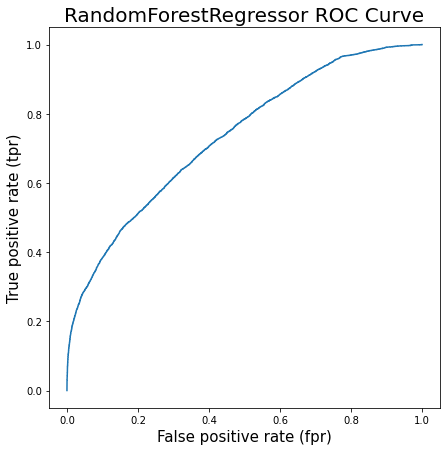

In [168]:
# plotting the area undre the curve.
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr)
plt.title('RandomForestRegressor ROC Curve', fontsize=20)
plt.xlabel('False positive rate (fpr)', fontsize=15)
plt.ylabel('True positive rate (tpr)', fontsize=15)

In [117]:
from skopt import gp_minimize, BayesSearchCV
from skopt.space import Real, Integer
from functools import partial
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold

In [191]:
xgb3 = BayesSearchCV(estimator=XGBRegressor(objective= 'binary:logistic',
                                          eval_metric = 'auc'),
                     search_spaces = {
                         'colsample_bytree': (0.01, 1.0, 'uniform'),
                         'gamma': (0.1, 9, 'uniform'),
                         'learning_rate': (0.01, 1.0, 'log-uniform'),
                         'max_depth': (1, 80),
                         'subsample': (0.01, 1.0, 'uniform'),
                         'reg_lambda': (1, 1000, 'log-uniform'),
                         'reg_alpha': (0.001, 1.0, 'log-uniform'),
                         'min_child_weight': (1, 10),
                         'n_estimators': (50, 100),
                         'scale_pos_weight': (1, 500, 'log-uniform')
                     },
                     
                     cv = StratifiedKFold(
                         n_splits=3,
                         shuffle=True,
                         random_state=42
                     ),
                     
                     n_iter = 32,
                     refit = True,
                     scoring = 'roc_auc',
                     random_state = 42)

def show_stats(result):
    '''
    Callback over the bayesian hyper-parameter search.
    '''
    
    # Models run added to DataFrame
    all_models = pd.DataFrame(xgb3.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(xgb3.best_params_)
    print('Parameter search {}  :  Best roc_auc: {}'.format(len(all_models),
                                                                 np.round(xgb3.best_score_, 4)
                                                                 #xgb3.best_params_
                                                                ))
    
    # Save all model results
    clf = xgb3.estimator.__class__.__name__
    all_models.to_csv(clf+"_cv_results.csv")

In [192]:
result = xgb3.fit(X_train.values, y_train.values, callback=show_stats)

Parameter search 1  :  Best roc_auc: 0.5801
Parameter search 2  :  Best roc_auc: 0.6222
Parameter search 3  :  Best roc_auc: 0.6222
Parameter search 4  :  Best roc_auc: 0.6222
Parameter search 5  :  Best roc_auc: 0.6222
Parameter search 6  :  Best roc_auc: 0.6222
Parameter search 7  :  Best roc_auc: 0.6222
Parameter search 8  :  Best roc_auc: 0.6222
Parameter search 9  :  Best roc_auc: 0.6222
Parameter search 10  :  Best roc_auc: 0.6222
Parameter search 11  :  Best roc_auc: 0.6222
Parameter search 12  :  Best roc_auc: 0.6222
Parameter search 13  :  Best roc_auc: 0.6222
Parameter search 14  :  Best roc_auc: 0.6222
Parameter search 15  :  Best roc_auc: 0.6222
Parameter search 16  :  Best roc_auc: 0.6222
Parameter search 17  :  Best roc_auc: 0.6222
Parameter search 18  :  Best roc_auc: 0.6222
Parameter search 19  :  Best roc_auc: 0.6222
Parameter search 20  :  Best roc_auc: 0.6222
Parameter search 21  :  Best roc_auc: 0.6222
Parameter search 22  :  Best roc_auc: 0.6222
Parameter search 23

In [197]:
xgb3.best_params_

OrderedDict([('colsample_bytree', 0.7375658622912902),
             ('gamma', 9),
             ('learning_rate', 0.012177406747973046),
             ('max_depth', 8),
             ('min_child_weight', 10),
             ('n_estimators', 100),
             ('reg_alpha', 0.0011115825570957012),
             ('reg_lambda', 282),
             ('scale_pos_weight', 170),
             ('subsample', 0.29155145587534137)])

In [ ]:
y_pred_xgb3 = xgb3.predict(X_test)

In [ ]:
# Lets see how well the model did.
fpr_xgb3, tpr_xgb3, threshold_xgb3 = roc_curve(y_test, y_pred_xgb3)
xgb_auc = auc(fpr_xgb3, tpr_xgb3)
xgb_auc

In [ ]:
# plotting the area undre the curve.
plt.figure(figsize=(7,7))
plt.plot(fpr_xgb3, tpr_xgb3)
plt.title('XGB ROC Curve', fontsize=20)
plt.xlabel('False positive rate (fpr)', fontsize=15)
plt.ylabel('True positive rate (tpr)', fontsize=15)

In [185]:
param_dist = {
    'learning_rate':0.08375495559514193,
    'n_estimators':10,
    'max_depth':38,
    'min_child_weight':8,
    'gamma':1.0,
    'subsample':0.41398375599088655,
    'colsample_bytree':0.5397364071090368,
    'objective':'binary:logistic',
    'nthread':4,
    'scale_pos_weight':250,
    'seed':0,
    'random_state':42,
    'alpha':1.0,
    'lambda':687
}

xgb2 = xgb.XGBModel(**param_dist)

xgb2.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='auc',
        verbose=True,
        early_stopping_rounds=30)

[0]	validation_0-auc:0.60066	validation_1-auc:0.50561
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.67780	validation_1-auc:0.55653
[2]	validation_0-auc:0.69589	validation_1-auc:0.58613
[3]	validation_0-auc:0.71146	validation_1-auc:0.59157
[4]	validation_0-auc:0.71815	validation_1-auc:0.61264
[5]	validation_0-auc:0.72452	validation_1-auc:0.61784
[6]	validation_0-auc:0.72610	validation_1-auc:0.62503
[7]	validation_0-auc:0.73662	validation_1-auc:0.62715
[8]	validation_0-auc:0.74607	validation_1-auc:0.62556
[9]	validation_0-auc:0.75180	validation_1-auc:0.62684


XGBModel(alpha=1.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=0.5397364071090368, gamma=1.0,
         gpu_id=-1, interaction_constraints='', lambda=687,
         learning_rate=0.08375495559514193, max_delta_step=0, max_depth=38,
         min_child_weight=8, monotone_constraints='()', n_estimators=10,
         n_jobs=4, nthread=4, num_parallel_tree=1, objective='binary:logistic',
         random_state=42, reg_alpha=1, reg_lambda=687, scale_pos_weight=250,
         seed=0, subsample=0.41398375599088655, tree_method='exact',
         validate_parameters=1)

In [166]:
y_pred_xgb = xgb2.predict(X_test)

In [167]:
# Lets see how well the model did.
fpr_xgb, tpr_xgb, threshold_xgb = roc_curve(y_test, y_pred_xgb)
xgb_auc = auc(fpr_xgb, tpr_xgb)
xgb_auc

0.716623654606621

Text(0, 0.5, 'True positive rate (tpr)')

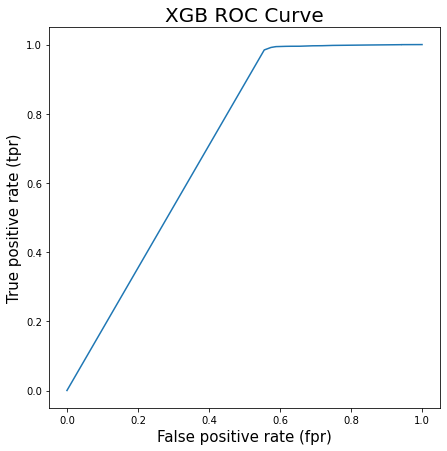

In [169]:
# plotting the area undre the curve.
plt.figure(figsize=(7,7))
plt.plot(fpr_xgb, tpr_xgb)
plt.title('XGB ROC Curve', fontsize=20)
plt.xlabel('False positive rate (fpr)', fontsize=15)
plt.ylabel('True positive rate (tpr)', fontsize=15)

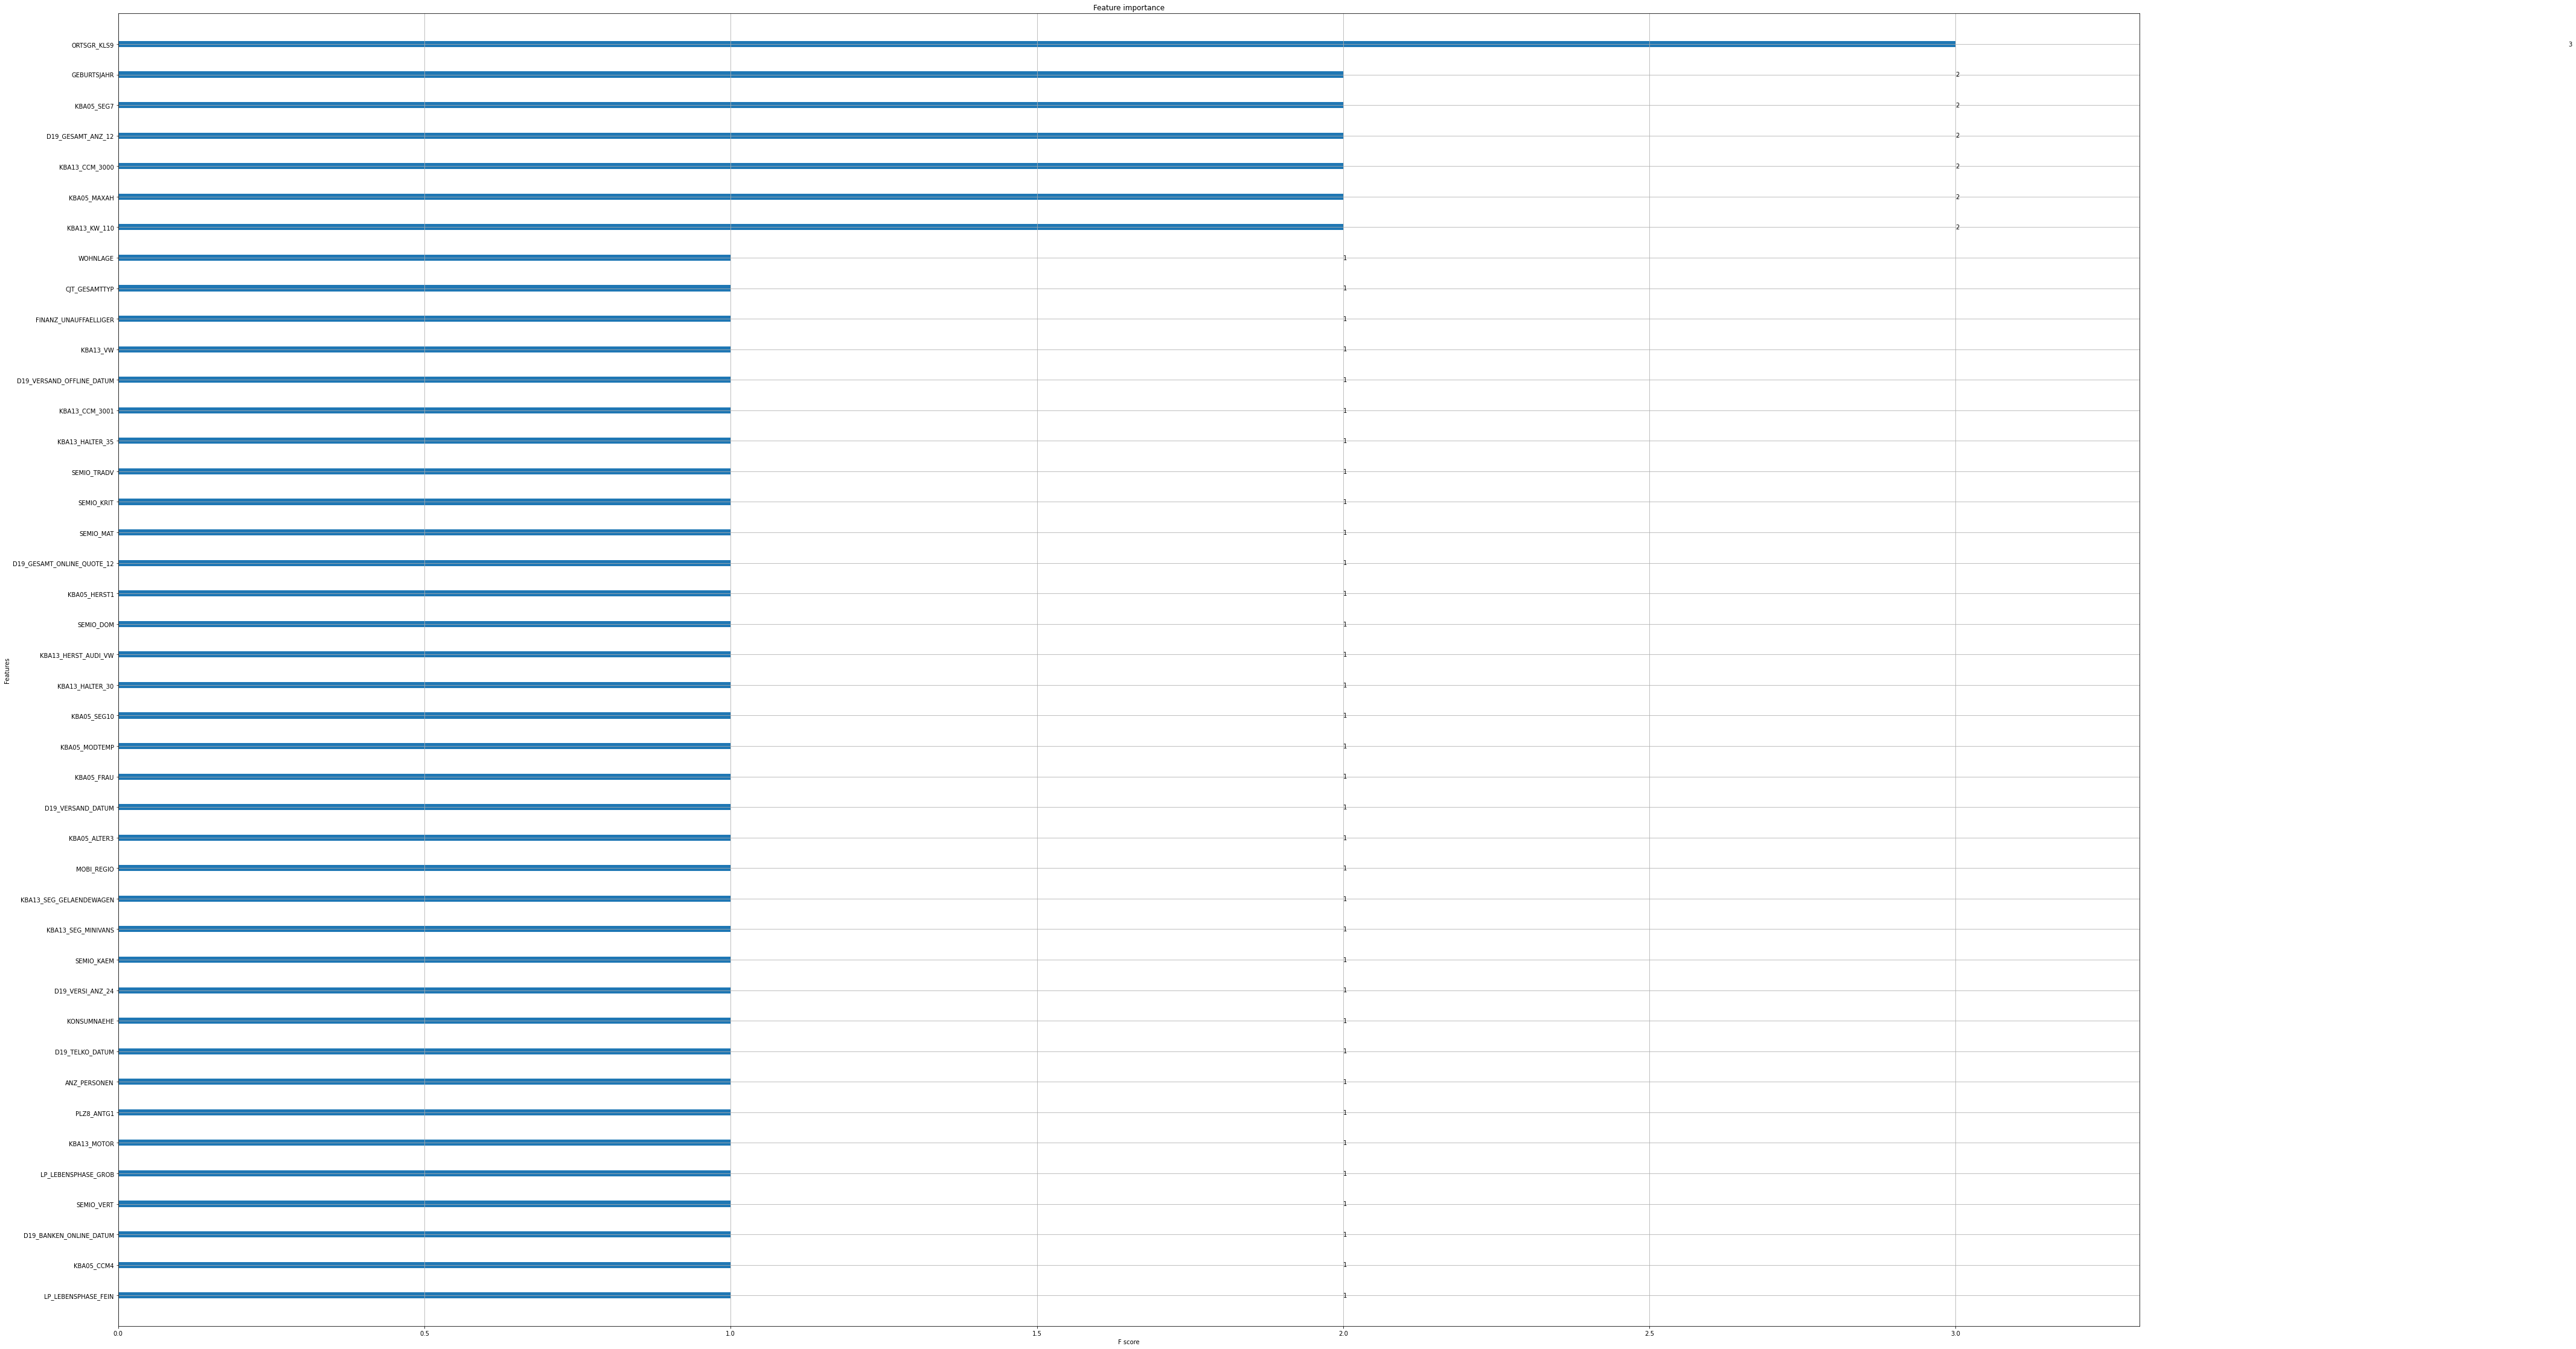

In [134]:
xgb.plot_importance(xgb2)
plt.rcParams['figure.figsize']=[60,40]

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [138]:
test_labels = xgb2.predict(test_features_im)

submission = pd.DataFrame(test_labels, index=test_lrn.astype('int32'),
                         columns=['RESPONSE'])

In [150]:
rf_test_labels = rf_model.predict(test_features_im)

submission = pd.DataFrame(rf_test_labels, index=test_lrn.astype('int32'),
                         columns=['RESPONSE'])

In [151]:
submission.head()

,RESPONSE
LNR,
1754,0.018818
1770,0.023469
1465,0.005528
1470,0.006955
1478,0.022556


In [152]:
submission[submission['RESPONSE'] > 0.01]

,RESPONSE
LNR,
1754,0.018818
1770,0.023469
1478,0.022556
1485,0.026410
1519,0.013843
...,...
66670,0.018217
67305,0.017390
67310,0.013209


In [153]:
# Save the file for submission.
submission.to_csv('submission.csv')